# Image Captioning with LSTMs

![A blueprint for an Image Captioning model](./assets/shikib.png)

Image captioning is a popular research area in deep learning that involves generating natural language descriptions of images. It is a challenging task that requires combining both computer vision and natural language processing (NLP) techniques to create a model capable of understanding the visual content of an image and generating a coherent and semantically meaningful sentence.

One of the most successful approaches for image captioning involves the use of Long Short-Term Memory (LSTM) networks. LSTMs are a type of recurrent neural network (RNN) that can capture long-term dependencies and patterns in sequential data, such as text. By incorporating LSTMs into an image captioning model, it becomes possible to generate captions that are not only accurate but also contextually relevant and coherent.

In [1]:
# Imports here
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import spacy

import torch
from torch import nn
import torchvision
import torchvision.models as models
from torchvision.transforms import transforms
from torch import optim
from torch.utils.data import DataLoader, Dataset


import warnings
warnings.filterwarnings('ignore')

print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


## Step 0: Load the data

Setup the directory structure as follows (names may vary from the dataset shared):
```
Image Captioning.ipynb
flickr8k
    images/
    captions.txt
```

Preprocessing the data is notoriously difficult in NLP. Everything has been implemented for you in this section so you need not worry about the details regarding Tokenization, and setting up the Vocabulary and whatnot.

Do read through the code to have a rough idea of what's going on behind the scenes: how we create a vocabulary for our text-based model based off tokens that occur frequently *enough* in our dataset, how we deal with numericalizing the strings, how we set up our inputs and labels etc.

In [2]:
# Use Spacy for tokenization
spacy_eng = spacy.load('en_core_web_sm')

# Create the Vocabulary class
class Vocabulary:
    def __init__(self, freq_threshold):
        '''
        Initialize the Vocabulary class.
        The freq_threshold is the minimum frequency needed to include a token in the vocabulary, otherwise it is replaced by <UNK>.
        '''
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}
        self.freq_threshold = freq_threshold # threshold for including a word in the vocabulary

    def __len__(self):
        '''
        Returns the length of the vocabulary.
        '''
        return len(self.itos)
    
    def tokenizer_eng(self, text):
        '''
        Tokenizes English text from a string into a list of strings (tokens) and reverses it
        '''
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocabulary(self, sentence_list):
        '''
        Builds a vocabulary from a list of sentences.
        This involves tokenizing the sentences and adding the tokens to the vocabulary.
        Tokens will only be added to the vocab if their frequences exceed the predefined threshold.
        '''

        # Dictionary to store the frequency of each word in the training set
        frequencies = {}
        idx = 4

        # Loop through the sentences
        for sentence in sentence_list:

            # Loop through the list of tokens in the sentence and update the frequencies dictionary
            for word in self.tokenizer_eng(sentence):

                # Update word frequency
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1

                # Add the word to the vocabulary if it exceeds the frequency threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        '''
        Converts a list of tokens into their corresponding indices.
        '''

        # Tokenize the text
        tokenized_text = self.tokenizer_eng(text)

        # Return a list of numericalized tokens
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]
    

# Create the FlickrDataset class
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        '''
        Initialize the dataset.
        '''
        self.root_dir = root_dir
        self.captions_df = pd.read_csv(captions_file)
        self.transform = transform

        # Get the images and the captions
        self.imgs, self.captions = self.captions_df['image'], self.captions_df['caption']

        # Initialize the vocabulary and build it
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        '''
        Returns the length of the dataset.
        '''
        return len(self.captions)
    
    def __getitem__(self, index):
        '''
        Returns an image and its corresponding caption.
        '''
        caption = self.captions[index]
        img_id = self.imgs[index]

        # TODO: Read in the image using the image id (may have to fix this)
        img = Image.open(os.path.join(self.root_dir, "images", img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        # Convert caption (string) to numericalized tokens
        # The caption would look something like: [SOS, 123, 456, 789, EOS]
        caption = [self.vocab.stoi["<SOS>"]] + self.vocab.numericalize(caption) + [self.vocab.stoi["<EOS>"]]
        caption = torch.tensor(caption)

        # Input: Image, Target: Caption
        return img, caption
    

# Create a Collater for the DataLoader
class Collate:
    def __init__(self, pad_idx):
        '''
        Initialize the collate function.
        This is necessary to provide to the DataLoader, so that it can pad the captions to some fixed length.
        '''
        self.pad_idx = pad_idx

    def __call__(self, batch):
        '''
        Collate takes a list of samples returned by the dataset and creates a mini-batch.
        '''
        # Get the images
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)

        # Get the captions and pad them
        targets = [item[1] for item in batch]
        targets = nn.utils.rnn.pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets
    
# Create the DataLoader
def get_loader(root_folder, annotation_file, transform, batch_size, shuffle=True):
    '''
    Returns a DataLoader for the dataset.
    '''
    
    # Create the dataset
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    # Get the token to pad the captions with (if they are shorter than some threshold)
    pad_idx = dataset.vocab.stoi["<PAD>"]

    # Create the DataLoader
    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        pin_memory=True,
        collate_fn=Collate(pad_idx=pad_idx)
    )

    return loader, dataset

# Get the DataLoader
loader, dataset = get_loader(
    root_folder="E:/Data/lstm/flickr8k",
    annotation_file="./flickr8k/captions.txt",
    transform=transforms.ToTensor(),
    batch_size=32
)

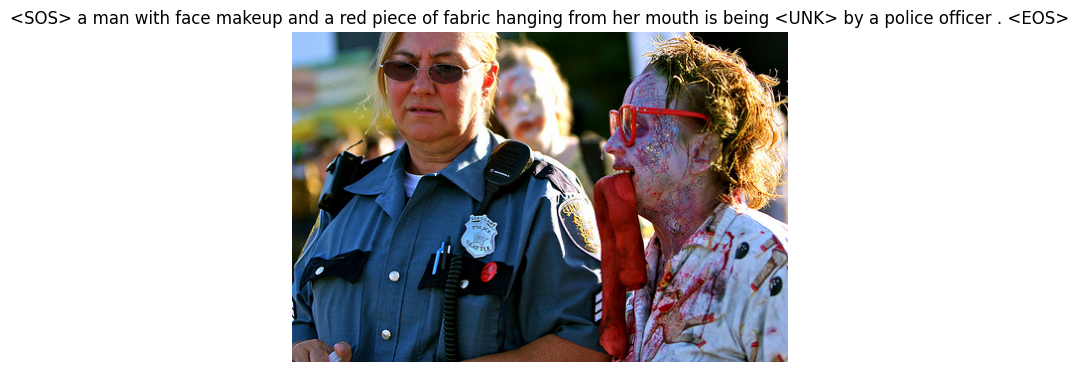

In [3]:
# Show an example
rand_idx = np.random.randint(0, len(dataset))
img, caption = dataset[rand_idx]
plt.imshow(img.permute(1,2,0))
plt.axis(False)


# Get the caption (the dataset provides it in numericalized form)
text_caption = []
for word_idx in caption:
    text_caption.append(dataset.vocab.itos[word_idx.item()])
text_caption = ' '.join(text_caption)    
plt.title(text_caption)

plt.show()

## Step 1: Making a CNN Encoder

By now you should have a good guess that the input to our grand model is a single image, on which we want to base a caption off.

In the diagram at the start of the notebook, note how there's a CNN "Encoder" responsible for creating a rich feature representation of the image. The objective of the model you will implement in this section is to take in an image, pass it through some layers to generate a feature vector whose size we specify. It is very similar to what happens within an Autoencoder if any bells start ringing.

Since we don't want to bother training a model from scratch, we will use a pretrained model here: specifically EfficientNetB2 (which performs well, and is relatively lightweight). We will bring in the pretrained weights and **freeze them** so that they are not changed during the training process (think about why this is efficient). We will replace the head of this model with our own Linear layer which condenses the final activation into the vector whose size we want.

In [4]:

from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
class CNNEncoder(nn.Module):
    def __init__(self, embed_size):
        super().__init__()

        self.embed_size = embed_size
        
        # TODO: Get a pretrained model Feature Extractor (use EfficientNet-B2)
        # model_weights = torchvision.
        self.pretrained_encoder = efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT)

        # TODO: Freeze the pretrained model
        for param in self.pretrained_encoder.parameters():
            param.requires_grad = False

        # TODO: Change the output layer to project the features to the desired embedding size
        self.pretrained_encoder.classifier[-1] = nn.Linear(1408, embed_size)

        # TODO: Make sure that the output layer is not frozen
        self.pretrained_encoder.classifier[-1].weight.requires_grad = True
        self.pretrained_encoder.classifier[-1].bias.requires_grad = True

        # Other layers
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)


    def forward(self, images):
        '''
        Pass the images through the CNN encoder -> ReLU -> Dropout layers.
        '''
        return self.dropout(self.relu(self.pretrained_encoder(images)))

In [5]:
# Test whether this Encoder works
cnn_encoder = CNNEncoder(embed_size=256)

# Pass the image from above into the model (note the output shape)
encoder_features = cnn_encoder(img.unsqueeze(0))
print(f"CNN Encoder output shape: {encoder_features.shape}")

CNN Encoder output shape: torch.Size([1, 256])


## Step 2: Making an RNN Decoder

Now that we have some nice features extracted from our model, we will hand this learned representation over to the LSTM decoder. This will take in that singular input, and generate a Sequence from it, which will be the Caption for that image.

Note that in this model, we will actually provide the ground truth captions to the model during training. This is something called "Teacher Forcing": if at any point, the Decoder predicts a wrong word, the following predictions will also be messed up and hence will be penalized. In this event, we provide the ground truth captions so that the Decoder has something correct to work off at every time-step (think about this like avoiding "Error Carried Forward" in your exams).

Also note the use of Embeddings here. We have to encode our captions while keeping its semantics (mostly) intact, which is why we take this approach as compared to One-Hot Encoding them.

In [6]:
class RNNDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super().__init__()

        # TODO: Embedding layer to convert word indices to word embeddings
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # TODO: LSTM layer to process the sequence of embeddings
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)

        # TODO: Linear layer to map the hidden state to the vocabulary
        self.linear = nn.Linear(hidden_size, vocab_size)
        
        # Other layers
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        '''
        The features are the output of the CNN encoder
        The captions are the input to the RNN decoder. During the Training phase, the captions are the ground truth captions.
        '''

        # TODO: Generate the embeddings for the captions
        embeddings = self.embedding(captions)
        # TODO: Concatenate the features and the embeddings along the 0th dimension
        # Note: Add an extra dimension to the features to make it compatible with the embeddings
        # print('f:', features.shape, 'e:', embeddings.shape)
        embeddings = torch.cat((features.unsqueeze(dim=0), embeddings))
        # print('concat:',embeddings.shape)
        # TODO: Process the embeddings using the LSTM layer
        lstm_out, _ = self.lstm(embeddings)

        # TODO: Map the LSTM output to the vocabulary
        out = self.linear(lstm_out)
        # print(out.shape,'l',lstm_out.shape)
        return out

In [7]:
# Test whether this Decoder works
rnn_decoder = RNNDecoder(embed_size=256, hidden_size=256, vocab_size=len(dataset.vocab), num_layers=1)
print(f"Vocab Size: {len(dataset.vocab)}")

# Pass the Encoder features through this Decoder
# Note how it takes a single feature vector and single caption (at a given time)
decoded_out = rnn_decoder(encoder_features.squeeze(), caption)
print(f"Decoder Output shape: {decoded_out.shape}")
# Think about what the shape represents (along the lines of probabilities for vocab tokens)

Vocab Size: 2994
Decoder Output shape: torch.Size([26, 2994])


## Step 3: Bringing it together

Congrats! Now that you've made the Encoder and Decoder, we bring them together into one grand model.

The meaty part here is the `caption_image` function that will take in a raw image, perform *all* the computations, and present the final generated caption (perfectly formatted and stringified). Since this has to generalize to new examples, we will not be able to take in the captions from the dataset as we did before. There is no notion of Teacher Forcing here.

Note: You will only get full marks in this section (Step 3) if the final model shows improvement via the loss decreasing in Step 4 (next section). If you've written sensible code here but the model malfunctions, the max you will get is 10 Marks here (assuming the model outputs something).

In [8]:
class CaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        # Encoder and Decoder
        self.encoder = CNNEncoder(embed_size)
        self.decoder = RNNDecoder(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        # Get the features from the encoder
        features = self.encoder(images)

        # Pass the features and the captions to the decoder
        out = self.decoder(features, captions)
        
        return out

    def caption_image(self, image, vocabulary, max_len=50):

        # TODO: Create a list to store the caption as its generated
        result_caption = []

        with torch.no_grad():

            # TODO: Get the image features from the encoder and add an extra dimension along the 0th axis
            x = self.encoder(image)
            x = x.unsqueeze(0)

            # Initialize the hidden state and cell state of the LSTM
            states = None

            ## Generate the caption
            # Loop until the model hits max length
            for _ in range(max_len):

                # TODO: Pass the features and the previous hidden state to the decoder
                hiddens, states = self.decoder.lstm(x, states)
                states = (states[0].squeeze(1), states[1].squeeze(1))

                # TODO: Map the hidden state to the vocabulary
                # Squeeze the hidden state to make it compatible with the linear layer
                output = self.decoder.linear(hiddens.squeeze())
                
                # TODO: Take the argmax of the output along dimension 1 (the second dim) to get the index of the word with the highest probability
                predicted = output.argmax(0)

                # Append the predicted word to the caption
                result_caption.append(predicted.item())

                # TODO: Pass the predicted word to the embedding layer to get the embedding for the next time step
                x = self.decoder.embedding(predicted).unsqueeze(0)

                # TODO: Break if the model predicts the <EOS> token
                # Hence, the caption will end when the model predicts the <EOS> token
                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        # Convert the list of indices to a list of words
        return [vocabulary.itos[idx] for idx in result_caption]

Now that the blueprint of the model is ready, we have to create the DataLoaders again. This is because the Encoder contains a pretrained model that had augmented the data in a specific way when it was trained before. For example, EfficientNetB2 expects images to be 288x288 in space, and normalized according to the ImageNet statistics. If you haven't used a different model, don't worry about any implementation details here.

In [9]:
# Create the transforms for the images
# This will depend on the model you are using in the encoder
# If you used EffNetB2 as instructed, the transforms have been done for you :)

effnet_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(288),
    transforms.CenterCrop(288),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# TODO: Create the DataLoader with these new transforms (may have to fix this)
loader, dataset = get_loader(
    root_folder="./flickr8k",
    annotation_file="./flickr8k/captions.txt",
    transform=effnet_tfms,
    batch_size=32
)

In [10]:
# Check if the model outputs something (hasn't been trained yet)
model = CaptioningModel(embed_size=256, hidden_size=256, vocab_size=len(dataset.vocab), num_layers=1)
raw_caption = model.caption_image(img.unsqueeze(0), dataset.vocab)

print(f"Model output: {' '.join(raw_caption)}")

Model output: beginning chews bright ribbon target frames stretch lasso toddlers interesting sad breath biting tussle headset doing messy branch biting fireman dancer beside return play pretend brick strapped very luggage tray skate lane pizza chew smelling town dive floaties blanket orange close marching suit suit grabs theater sits great downhill haired


## Step 4: Training the Model

Hopefully you're in awe of the fact that you just created a model that captions an image. It's not that good right now though.

Let's train it using the Dataset we bought in earlier.

Most of the code has been provided here, you need only specify what the inputs and outputs should be for the overall model here (in the Forward pass and the Loss calculation).

In [11]:
import time

# Create dataset and dataloader (if you haven't run the above cells)

# Hyperparameters
embed_size = 256
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 1
learning_rate = 3e-4
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model
model = CaptioningModel(embed_size, hidden_size, vocab_size, num_layers).to(device)

# Initialize loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(
        model,
        train_loader=loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=num_epochs,
        device=device,        
        tfms=effnet_tfms
    ):
    
    model.train()
    epoch_losses = []


    for epoch in range(num_epochs):

        epoch_loss = 0
        epoch_start = time.time()

        for imgs, captions in train_loader:

            # Cast the images and captions to the device
            imgs = imgs.to(device)
            captions = captions.to(device)

            # TODO: Forward pass
            # Recall we pass both the images and the captions to the model
            # Note that we do not include the <EOS> token in the captions (hint: captions[:-1])
            outputs = model(imgs, captions[:-1])

            # TODO: Calculate the loss
            # Recall that the outputs are of shape (seq_len, batch_size, vocab_size)
            # and the captions are of shape (batch_size, seq_len)
            # Hence, we need to reshape the outputs to (seq_len * batch_size, vocab_size) before passing to the loss_fn
            # Hint: Use the .reshape(???) method on the outputs, and the .reshape(-1) method on the captions
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
            )

            # Zero the gradients
            optimizer.zero_grad()
            
            # Backward pass
            loss.backward(loss)

            # Update the parameters
            optimizer.step()

            epoch_loss += loss.item()
            
        print(f"Epoch {epoch+1} finished in {time.time()-epoch_start} seconds...")
        
        print('-'*20)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")
        print('-'*20)
            
        epoch_losses.append(epoch_loss/len(train_loader))
        
    return epoch_losses

In [12]:
losses = train(model)

Epoch 1 finished in 525.5335042476654 seconds...
--------------------
Epoch [1/10], Loss: 3.7102
--------------------
Epoch 2 finished in 680.6066854000092 seconds...
--------------------
Epoch [2/10], Loss: 3.0550
--------------------
Epoch 3 finished in 1989.3765542507172 seconds...
--------------------
Epoch [3/10], Loss: 2.8230
--------------------
Epoch 4 finished in 461.4419991970062 seconds...
--------------------
Epoch [4/10], Loss: 2.6704
--------------------
Epoch 5 finished in 429.1840305328369 seconds...
--------------------
Epoch [5/10], Loss: 2.5588
--------------------
Epoch 6 finished in 420.1805396080017 seconds...
--------------------
Epoch [6/10], Loss: 2.4730
--------------------
Epoch 7 finished in 421.38951206207275 seconds...
--------------------
Epoch [7/10], Loss: 2.4021
--------------------
Epoch 8 finished in 419.99200105667114 seconds...
--------------------
Epoch [8/10], Loss: 2.3418
--------------------
Epoch 9 finished in 432.84316325187683 seconds...
---

Text(0, 0.5, 'Loss')

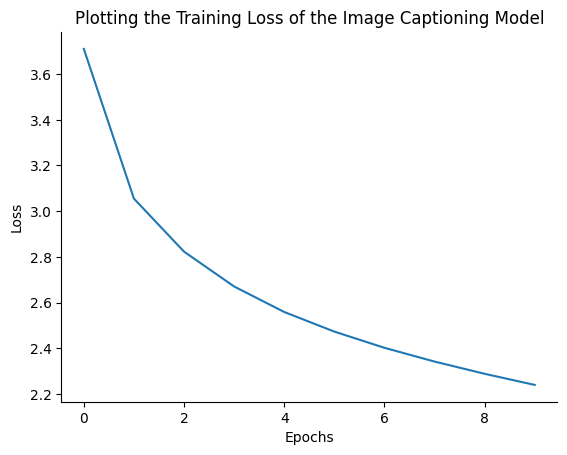

In [13]:
# Plot the loss curve
import seaborn as sns
plt.plot(losses)

sns.despine()
plt.title("Plotting the Training Loss of the Image Captioning Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")

## Step 5: Testing it out

Here's hoping you must be seeing the loss go down in the above cell.

Now try out your trained model on some images and see how it performs. Maybe try it on some of your own images and see if it makes any sense.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[CORRECT CAPTION]: <SOS> a black dog chasing geese . <EOS>
-------------------------
[OUTPUT]: <SOS> a dog is running through a field of grass . <EOS>


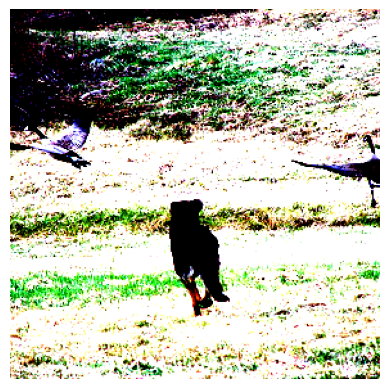

In [24]:
# Using the model we just trained
model.eval()

# Get a random image from the dataset
idx = np.random.randint(0, len(dataset))
image, correct_caption = dataset[idx]

# Get the caption for the image
caption = model.caption_image(image.unsqueeze(0).to(device), dataset.vocab)

plt.imshow(image.permute(1,2,0))
plt.axis(False)

# Print the caption
correct_caption_decoded = []
for word_idx in correct_caption:
    try:
        correct_caption_decoded.append(dataset.vocab.itos[int(word_idx)])
    except:
        continue
print(f"[CORRECT CAPTION]: {' '.join(correct_caption_decoded)}")
print('-'*25)
print(f"[OUTPUT]: {' '.join(caption)}")